<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment7/Assignment_7_IDL_NMT_Meghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

# Import statements

In [ ]:
pip install tensorflow_text

In [ ]:
import os
import sys
import numpy as np
from datetime import datetime
import tensorflow as tf
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow_text as tf_text
import typing
from typing import Any, Tuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Change the directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
working_directory = '/content/drive/MyDrive/kan-eng'
def colabDrive():
    from google.colab import drive
    drive.mount("/content/drive")

    if os.getcwd() !=  working_directory:
      os.chdir(working_directory)
    print(os.getcwd())

In [ ]:
colabDrive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/kan-eng


# Preamble

## Helper function which can be used to check the shapes

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## Load Data

In [ ]:
def load_data(path):
  #text = path.read_text(encoding='utf-8')
  with open(path, "r", encoding='utf-8') as kan:
    kannada_text=kan.read()

  lines = kannada_text.splitlines()
  pairs = [line.split('\t')[:-1]  for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [ ]:
targ, inp = load_data("/content/drive/MyDrive/kan-eng/kan.txt")
print(inp)
print(targ)

['ಆರಾಮಾ?', 'ಹೇಗಿದ್ದೀರ', 'ಟಾಮ್ ಏಳಿದನು.', 'ಅರ್ಧ ನನಗೆ ಕೊಡು.', 'ನಮಗೆ ಬೇಕಾಗಿತ್ತು.', 'ನಾನು ತುಂಬಾ ಬಿಝಿ', 'ಟಾಮ್ ನಿನ್ನನ್ನು ಬಯಸಿದನು.', 'ಒಳಗೆ ಹೋಗು ಅಷ್ಟೇ.', 'ನಿಮಗೆ ನೆನಪು ಇದ್ಯಾ?', 'ನಾನು ಈಗ ತಾನೇ ವಾಪಸ್ಸು ಬಂದೆ.', 'ಎರಡು ವರೆಗೆ (೨.೩೦ ಗೆ) ನಿನ್ನನ್ನು ನೋಡುತ್ತೇನೆ.', 'ನಾವು ಒಳಗಡೆ ಹೋಗಬಹುದಾ?', 'ನಾನು ನಿನ್ನ ಮೇಲೆ ನಂಬಿಕೆ ಇಟ್ಟಿದ್ದೇನೆ.', 'ಮೇರಿ ಸೌಂದರ್ಯವಾಗಿದ್ದಾಳೆ.', 'ನಿಮ್ಮ ಮನೇಲಿ ಹೆಂಗಿದ್ದಾರೆ', 'ಪುಸ್ತಕ ಎಲ್ಲಿದೆ?', 'ಟಾಮ್ ನನ್ನ ಜೊತೆ ಉಳಿದುಕೊಂಡನು.', 'ಟೊಮನ್ನು ಅದನ್ನು ಮಾಡಕ್ಕೆ ಬಿಡಬೇಡಿ.', 'ಅವರು ಏನಕ್ಕೂ ಉಪಯೋಗವಿಲ್ಲ.', 'ನಾವು ಅದರ ಕುರಿತು ಕೆಲಸ ಮಾಡುತ್ತಾ ಇದ್ದೇವೆ.', 'ನಾನು ಒಂಟಿಯಾಗಿ ಪಯಣ ಮಾಡಿದೆ.', 'ಟಾಮ್ ತುಂಬಾನೇ ಅಸಡ್ಡೆ.', 'ಇಲ್ಲಿ ಏನು ನಡಿತಾಯಿದೆ?', 'ನೀವು ಟಾಮಿಗೆ ಹೇಳಲೇಬೇಕು.', 'ನೀನು ನನ್ನನು ನಿರಾಶೆ ಮಾಡುತ್ತೀಯ.', 'ಟಾಮ್ ನಿನ್ನನ್ನು ಯಾವಾಗಲಾದರೂ ನೋಯಿಸಿದ್ದಾನಾ?', 'ನಾನು ಟೊಮನ್ನು ಬಿಗಿಯಾಗಿ ತಬ್ಬಿಕೊಂಡೆ.', 'ಅದಷ್ಟೇ ಟಾಮಿಗೆ ಬೇಕಾಗಿದ್ದು.', 'ನಾನು ಮನೆಗೆ ಹೊರಡುತ್ತಾ ಇರಬೇಕು.', 'ಚನ್ನಾಗಿ ನಡೆಯಿತು ಅಂತ ಅನಿಸುತ್ತೆ.', 'ನಮ್ಮ ಅತಿಥಿಗಳನ್ನು ಸ್ವಾಗತಿಸೋಣ.', 'ಮೂರ್ಖತನಕ್ಕೆ ಯಾವ ಕ್ಷಮೆಯು ಇಲ್ಲ.', 'ನೀವು ಎಚ್ಚರವಾಗಿರಬೇಕು.', 'ಬಹಳ ತರಕಾರಿಗಳು ತಿನ್ನು.', 'ನಾನು ಸ್ವಲ್ಪ ದುಡ್ಡನ್ನು ತೆಗೆದುಕೊಂಡು ಬರಬೇಕಾಗಿತ್ತು.', 'ನಿಮ್ಮನ್ನು

## Create dataset

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 60

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)

test_dataset = dataset.take(20) 
train_dataset = dataset.skip(20)

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(20).shuffle(10, seed=45)

In [ ]:
for example_input_batch, example_target_batch in train_dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'\xe0\xb2\x95\xe0\xb3\x86\xe0\xb2\xb2\xe0\xb2\xb8\xe0\xb2\xa6\xe0\xb2\xb2\xe0\xb3\x8d\xe0\xb2\xb2\xe0\xb2\xbf \xe0\xb2\x85\xe0\xb2\xb5\xe0\xb2\xa8\xe0\xb2\xbf\xe0\xb2\x97\xe0\xb3\x86 \xe0\xb2\x85\xe0\xb2\xaa\xe0\xb2\x98\xe0\xb2\xbe\xe0\xb2\xa4\xe0\xb2\xb5\xe0\xb2\xbe\xe0\xb2\xaf\xe0\xb2\xbf\xe0\xb2\xa4\xe0\xb3\x81.'
 b'\xe0\xb2\xa8\xe0\xb2\xbe\xe0\xb2\xa8\xe0\xb3\x81 \xe0\xb2\x87\xe0\xb2\xb5\xe0\xb2\xa4\xe0\xb3\x8d\xe0\xb2\xa4\xe0\xb3\x81 \xe0\xb2\xac\xe0\xb3\x86\xe0\xb2\xb3\xe0\xb2\xbf\xe0\xb2\x97\xe0\xb3\x8d\xe0\xb2\x97\xe0\xb3\x86 \xe0\xb2\xac\xe0\xb3\x87\xe0\xb2\x97 \xe0\xb2\x8f\xe0\xb2\xb3\xe0\xb2\xac\xe0\xb3\x87\xe0\xb2\x95\xe0\xb2\xbe\xe0\xb2\x97\xe0\xb2\xbf\xe0\xb2\xa4\xe0\xb3\x8d\xe0\xb2\xa4\xe0\xb3\x81.'
 b'\xe0\xb2\x85\xe0\xb2\xb5\xe0\xb2\xa8\xe0\xb3\x81 \xe0\xb2\xa0\xe0\xb2\xbe\xe0\xb2\xa3\xe0\xb3\x86\xe0\xb2\x97\xe0\xb3\x86 \xe0\xb2\x90\xe0\xb2\xa6\xe0\xb3\x81 \xe0\xb2\x97\xe0\xb2\x82\xe0\xb2\x9f\xe0\xb3\x86\xe0\xb2\x97\xe0\xb3\x86 \xe0\xb2\xa4\xe0\xb2\xb2\xe0

## Unicode Normalization

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #text = tf.strings.regex_replace(text, '[^ a-z$ఀ-౿.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

## Text Vectorization

Creating a word to index dictionary and an index to word dictionary for all unique source and target words in the dataset.

### For Kannada language

In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', '?', 'ನಾನು', 'ಟಾಮ್', 'ನಿಮಗೆ', 'ನಾವು']

### For English language

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'you', 'to', 'the', 'i', '?']

### See some tokens

In [ ]:
example_inp_tokens = input_text_processor('ಆರಾಮಾ?')
example_inp_tokens

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  2, 447,   5,   3])>

In [ ]:
example_tar_tokens = output_text_processor('Whats up?')
example_tar_tokens

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 2,  1, 48,  9,  3])>

## Constants

In [ ]:
embedding_dim = 256
units = 1024

# Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (60,)
Input batch tokens, shape (batch, s): (60, 11)
Encoder output, shape (batch, s, units): (60, 11, 1024)
Encoder state, shape (batch, units): (60, 1024)


# Attention Layers

## Bahdanau Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

#Luong's Attention

In [ ]:
class LuongsAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.Attention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W`.
    w_query = self.W(query)
    shape_checker(w_query, ('batch', 't', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w_query, value],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(units)
attention_layer_2 = LuongsAttention(units)

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

#context_vector, attention_weights = attention_layer_2(
    #query=example_attention_query,
    #value=example_enc_output,
    #mask=(example_tokens != 0))--------------Luong's Attention

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (60, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (60, 2, 11)


# Decoder

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))

    if state is not None:
      shape_checker(state, ('batch', 'dec_units'))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

# Training

## Loss function

Summary:


*   Sparse Categorical crossentropy is the loss function
*   Not computing the loss where padding is applied



In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

## Train Model

Summary


1.   A constructor which will initialise Encoder, Decoder etc
2.   A **train_step** function which will choose which function to run whether the train step function which is wrapped with tf or the normal train step function.
3.   A  **_preprocess** function which will preprocess the data.
4.   A  **_train_step** function.
5.   A  **_tf_train_step** function wrapped like a tf function.
6.   A  **_loop_step** function.



In [ ]:
class TrainTranslator(tf.keras.Model):
  ## --------------------------------------------------Start of the Constructor----------------------------------------------------------
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()
  ## --------------------------------------------------End of the Constructor----------------------------------------------------------

  ## --------------------------------------------------Start of the Call----------------------------------------------------------
  def call(self, inputs):
    return self._test_step(inputs)
  ## --------------------------------------------------End of the Call----------------------------------------------------------

  ## --------------------------------------------------Start of the train step----------------------------------------------------------
  #Choose which train step to run
  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  ## --------------------------------------------------End of the train step----------------------------------------------------------

  ## --------------------------------------------------Start of the Preprocess data function----------------------------------------------------------
  def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask
  ## --------------------------------------------------End of the Preprocess data function----------------------------------------------------------

  ## --------------------------------------------------Start of the train step function definition----------------------------------------------------------
  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]
    

    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
      self.shape_checker(enc_state, ('batch', 'enc_units'))

      # Initialize the decoder's state to the encoder's final state.
      # This only works if the encoder and decoder have the same number of
      # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in tf.range(max_target_length-1):
        # Pass in two tokens from the target sequence:
        # 1. The current input to the decoder.
        # 2. The target for the decoder's next prediction.
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))


    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}
  ## --------------------------------------------------End of the train step function definition----------------------------------------------------------


  ## --------------------------------------------------Start of the test step evaluate function definition----------------------------------------------------------
  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _test_step(self, inputs):
    input_text, target_text = inputs  
    
    (input_tokens, input_mask,
    target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]
    
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                            enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}
  ## --------------------------------------------------End of the test step evaluate function definition----------------------------------------------------------

  ## --------------------------------------------------Start of the tf train step function ----------------------------------------------------------
  # wrap train step into tf function to speed up the process
  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)
  ## --------------------------------------------------Start of the tf train step function ----------------------------------------------------------


  ## --------------------------------------------------Start of the train loop function----------------------------------------------------------
  #The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).
  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state
   ## --------------------------------------------------End of the train loop function----------------------------------------------------------

## Test the Model to see whether it works or not for a single batch

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

....................................................................................................


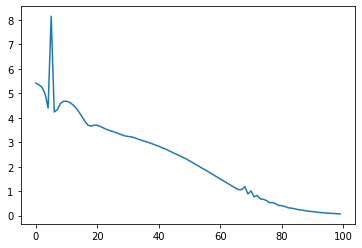

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

## Training the Model

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=True)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(train_dataset, epochs=100, callbacks=[batch_loss])

Epoch 1/100
3/3 [==============================] - 9s 382ms/step - batch_loss: 5.3361
Epoch 2/100
3/3 [==============================] - 1s 365ms/step - batch_loss: 5.7169
Epoch 3/100
3/3 [==============================] - 1s 402ms/step - batch_loss: 4.5481
Epoch 4/100
3/3 [==============================] - 1s 389ms/step - batch_loss: 4.6335
Epoch 5/100
3/3 [==============================] - 1s 411ms/step - batch_loss: 4.3830
Epoch 6/100
3/3 [==============================] - 1s 409ms/step - batch_loss: 4.0240
Epoch 7/100
3/3 [==============================] - 1s 369ms/step - batch_loss: 4.0825
Epoch 8/100
3/3 [==============================] - 1s 392ms/step - batch_loss: 4.0373
Epoch 9/100
3/3 [==============================] - 1s 390ms/step - batch_loss: 3.8578
Epoch 10/100
3/3 [==============================] - 1s 383ms/step - batch_loss: 3.7316
Epoch 11/100
3/3 [==============================] - 1s 353ms/step - batch_loss: 3.7170
Epoch 12/100
3/3 [==============================] - 

In [ ]:
losses = []
for test_input_batch, test_target_batch in test_dataset:
  logs = train_translator._test_step([test_input_batch, test_target_batch])
  losses.append(logs['batch_loss'].numpy())
print("Test loss: ",losses)

Test loss:  [0.0074260985]


# Create a Translater

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

  def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    shape_checker(result_text, ('batch'))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

  def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)

    shape_checker(new_tokens, ('batch', 't'))

    return new_tokens

  def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
      dec_input = DecoderInput(new_tokens=new_tokens,
                              enc_output=enc_output,
                              mask=(input_tokens!=0))

      dec_result, dec_state = self.decoder(dec_input, state=dec_state)

      attention.append(dec_result.attention_weights)

      new_tokens = self.sample(dec_result.logits, temperature)

      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens.append(new_tokens)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
kan1, kan2, kan3, kan4, kan5, eng1, eng2, eng3, eng4, eng5 = "","","","","","","","","",""

t1 = 'ಹೇಗಿದ್ದೀರ'
for test_input_batch, test_target_batch in test_dataset:
  kan1 = test_input_batch[0].numpy().decode()
  eng1 = test_target_batch[0].numpy().decode()
  kan2 = test_input_batch[1].numpy().decode()
  eng2 = test_target_batch[1].numpy().decode()
  kan3 = test_input_batch[6].numpy().decode()
  eng3 = test_target_batch[6].numpy().decode()
  kan4 = test_input_batch[8].numpy().decode()
  eng4 = test_target_batch[8].numpy().decode()
  kan5 = test_input_batch[13].numpy().decode()
  eng5 = test_target_batch[13].numpy().decode()

In [ ]:
%%time
input_text = tf.constant([kan1, kan2, kan3, kan4, kan5, t1])

result = translator.translate_unrolled(
    input_text = input_text)

CPU times: user 804 ms, sys: 13.6 ms, total: 818 ms
Wall time: 810 ms


## Kannada to English Translation

In [ ]:
print(kan1)
print(result['text'][0].numpy().decode())

ಆಹಾರಕ್ಕೆ ತುಂಬಾ ಎಣ್ಣೆ ಇತ್ತು ಅಂತ ಅನಿಸಿತು.
both my father and i went to the one who taught you was factory .


In [ ]:
print(kan2)
print(result['text'][1].numpy().decode())

ಅದು ಪರಿಹಾರ ಇಲ್ಲವೇ ಇಲ್ಲ.
that's not really a solution .


In [ ]:
print(kan3)
print(result['text'][2].numpy().decode())

ನಾನು ಏನನ್ನು ಮಾಡಬೇಕೆಂದು ಸರಿಯಾಗಿ ನೀವು ಹೇಳಬೇಕು.
you have to tell me exactly what i need to do .


In [ ]:
print(kan4)
print(result['text'][3].numpy().decode())

ಕುಡಿಯೋಕ್ಕೆ ಏನಾದ್ರು ಬೇಕಾ ?
do you need something to drink ?


In [ ]:
print(kan5)
print(result['text'][4].numpy().decode())

ಅಪಘಾತದ ಕಾರಣವೇ ಗೊತ್ತಿಲ್ಲ.
the cause of the accident is unknown .


In [ ]:
print(t1)
print(result['text'][5].numpy().decode())

ಹೇಗಿದ್ದೀರ
how are you ?


# Weights Analyse

In [ ]:
a = result['attention'][0]

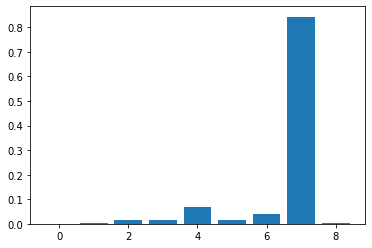

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  #ax.matshow(attention, cmap='viridis', vmin=0.0)
  ax.matshow(attention, cmap='viridis', vmin=0.0, vmax = 1)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

ಅದು ಪರಿಹಾರ ಇಲ್ಲವೇ ಇಲ್ಲ.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3242 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3248 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3263 missing from current font.
  font.set_text(s

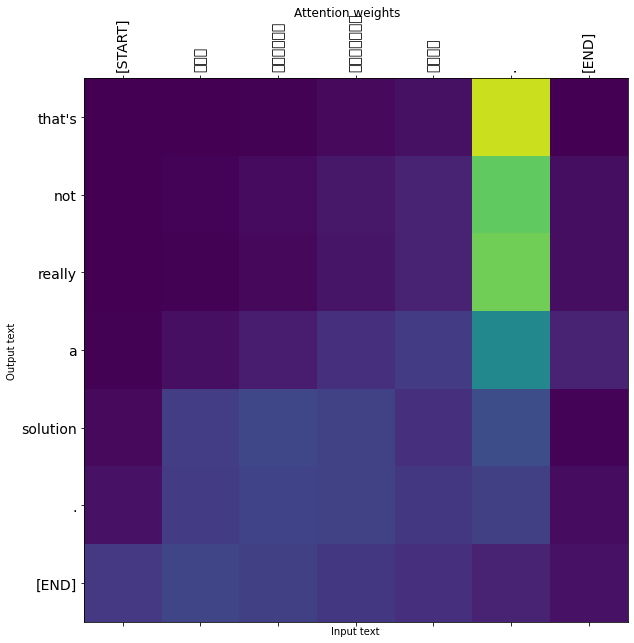

In [ ]:
i=1
plot_attention(result['attention'][i], input_text[i], result['text'][i])
print(input_text[i].numpy().decode())

# Questions & Answers

Q1-)Which parts of the sentence are used as a token? Each character, each word, or are some words split up?

Ans-) Each word.

Q-2) Do the same tokens in different language have the same ID?
e.g. Would the same token index map to the German word die and to the English word die?


Ans-) No. 

As example we can see below:

*  inp = 'die hallo morgen guten tag'
*  tar = 'Someone might die because of the situation'
*  inp_voc = [0 1 2 3 4 5]
*  tar_voc = [0 1 2 3 4 5 6]

Q-3)What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state (for the architecture used in the tutorial)?

Ans-) Encoder ouput is dependent on encoder hidden state whereas vice-versa isn't the same.

Q-4) Is the decoder attending to all previous positions, including the previous decoder predictions?

Ans-) No it will attend to just the previous decoder state and predictions

Q-5) Does the encoder output change in different decoding steps?

Ans-) Yes it computes attention weights dynamically for every decoder step.

Q-6) Does the context vector change in different decoding steps?

Ans-) Yes

Q-7) The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

Ans-) No because even the previous decoder state is also connected to the current decoder state.

Q-8) Why is a mask applied to the loss function?

Ans-) To skip the zero padded cells in the sequences.

Q-9) When translating the same sentence multiple times, do you get the same result? Why (not)? If not, what changes need to be made to get the same result each time?

Ans-) The output is not consistent.

# References



1.   https://www.tensorflow.org/text/tutorials/nmt_with_attention
2.   https://ovgu-ailab.github.io/idl2021/ass7.html

